In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install timm scikit-learn tqdm


In [3]:
from pathlib import Path
import json, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import timm
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

META_DIR   = PROJECT_ROOT / "data" / "10_images" / "metadata"
INDEX_CSV  = META_DIR / "image_index_concerns.csv"
LABEL_JSON = META_DIR / "label_map_concerns.json"

MODELS_DIR  = PROJECT_ROOT / "models" / "vision"
RESULTS_DIR = PROJECT_ROOT / "results"

(MODELS_DIR).mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "metrics").mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "confusion_matrices").mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "sample_outputs").mkdir(parents=True, exist_ok=True)

assert INDEX_CSV.exists(), f"Missing: {INDEX_CSV}"
assert LABEL_JSON.exists(), f"Missing: {LABEL_JSON}"

print("✅ INDEX:", INDEX_CSV)
print("✅ LABEL:", LABEL_JSON)


✅ INDEX: /content/drive/MyDrive/SkinCare_AI_Component/data/10_images/metadata/image_index_concerns.csv
✅ LABEL: /content/drive/MyDrive/SkinCare_AI_Component/data/10_images/metadata/label_map_concerns.json


In [4]:
with open(LABEL_JSON, "r") as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

df = pd.read_csv(INDEX_CSV)

print("Rows:", len(df))
print(df["split"].value_counts())
print("num_classes:", num_classes)
print("labels:", label_map)


Rows: 9444
split
train    6431
test     1510
val      1503
Name: count, dtype: int64
num_classes: 6
labels: {'acne': 0, 'dark_spots': 1, 'wrinkles': 2, 'redness_prone': 3, 'dry_irritated': 4, 'normal': 5}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.backends.cudnn.benchmark = True
use_amp = (device.type == "cuda")
print("AMP enabled:", use_amp)


Device: cuda
AMP enabled: True


In [6]:
class SkinDataset(Dataset):
    def __init__(self, df, project_root: Path, transform=None):
        self.df = df.reset_index(drop=True)
        self.project_root = project_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.project_root / row["image_path"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label, str(row["image_path"])


In [7]:
train_df = df[df["split"]=="train"].copy()
val_df   = df[df["split"]=="val"].copy()
test_df  = df[df["split"]=="test"].copy()

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 6431 Val: 1503 Test: 1510


In [8]:
IMG_SIZE = 224

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [9]:
BATCH_SIZE = 32 if device.type == "cuda" else 8

train_ds = SkinDataset(train_df, PROJECT_ROOT, transform=train_tfms)
val_ds   = SkinDataset(val_df,   PROJECT_ROOT, transform=eval_tfms)
test_ds  = SkinDataset(test_df,  PROJECT_ROOT, transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# quick sanity
batch = next(iter(train_loader))
print("✅ First batch:", batch[0].shape, batch[1].shape)


✅ First batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

EPOCHS = 8 if device.type == "cuda" else 5
print("Epochs:", EPOCHS)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epochs: 8


In [11]:
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss, total_correct, total_seen = 0.0, 0, 0
    pbar = tqdm(loader, desc=("Train" if train else "Val"), leave=False)

    for imgs, labels, _paths in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(imgs)
                loss = criterion(logits, labels)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_seen += imgs.size(0)
        total_loss += loss.item() * imgs.size(0)

        pbar.set_postfix(loss=f"{total_loss/max(1,total_seen):.4f}",
                         acc=f"{total_correct/max(1,total_seen):.4f}")

    return total_loss/max(1,total_seen), total_correct/max(1,total_seen)


/tmp/ipython-input-515302831.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [12]:
best_val_acc = -1.0
best_path = MODELS_DIR / "concerns_best.pt"
last_path = MODELS_DIR / "concerns_last.pt"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)
    dt = time.time() - t0

    print(f"Epoch {epoch}/{EPOCHS} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | {dt:.1f}s")

    # save last
    torch.save({"model_state": model.state_dict(), "label_map": label_map}, last_path)

    # save best
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({"model_state": model.state_dict(), "label_map": label_map}, best_path)
        print("✅ Saved BEST:", best_path, "val_acc:", best_val_acc)

print("✅ Training finished. Best val_acc:", best_val_acc)


Train:   0%|          | 0/201 [00:00<?, ?it/s]/tmp/ipython-input-515302831.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1/8 | train 0.5086/0.8193 | val 0.4331/0.8510 | 4041.7s
✅ Saved BEST: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/concerns_best.pt val_acc: 0.850964737192282


Epoch 2/8 | train 0.2660/0.9061 | val 0.4045/0.8636 | 135.0s
✅ Saved BEST: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/concerns_best.pt val_acc: 0.863606121091151


Epoch 3/8 | train 0.2176/0.9235 | val 0.3881/0.8743 | 134.2s
✅ Saved BEST: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/concerns_best.pt val_acc: 0.874251497005988


Epoch 4/8 | train 0.1791/0.9358 | val 0.3300/0.8969 | 134.6s
✅ Saved BEST: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/concerns_best.pt val_acc: 0.8968729208250167


Epoch 5/8 | train 0.1511/0.9479 | val 0.3256/0.8955 | 134.4s


Epoch 6/8 | train 0.1219/0.9585 | val 0.3071/0.9155 | 133.4s
✅ Saved BEST: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/concerns_best.pt val_acc: 0.9155023286759814


Epoch 7/8 | train 0.1307/0.9563 | val 0.4023/0.8802 | 134.4s


Epoch 8/8 | train 0.1078/0.9610 | val 0.4162/0.8822 | 133.3s
✅ Training finished. Best val_acc: 0.9155023286759814


In [13]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

all_true, all_pred, all_paths = [], [], []

with torch.no_grad():
    for imgs, labels, paths in tqdm(test_loader, desc="Test", leave=False):
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_true.extend(labels.numpy().tolist())
        all_pred.extend(preds.tolist())
        all_paths.extend(paths)

labels_all = list(range(num_classes))
target_names_all = [id_to_label[i] for i in labels_all]

report_dict = classification_report(
    all_true, all_pred,
    labels=labels_all,
    target_names=target_names_all,
    output_dict=True,
    zero_division=0
)
cm = confusion_matrix(all_true, all_pred, labels=labels_all)

print("✅ Test Accuracy:", report_dict["accuracy"])
print("✅ Macro F1:", report_dict["macro avg"]["f1-score"])


✅ Test Accuracy: 0.9245033112582781
✅ Macro F1: 0.9126674033540136


✅ Saved metrics: /content/drive/MyDrive/SkinCare_AI_Component/results/metrics/concerns_metrics.json


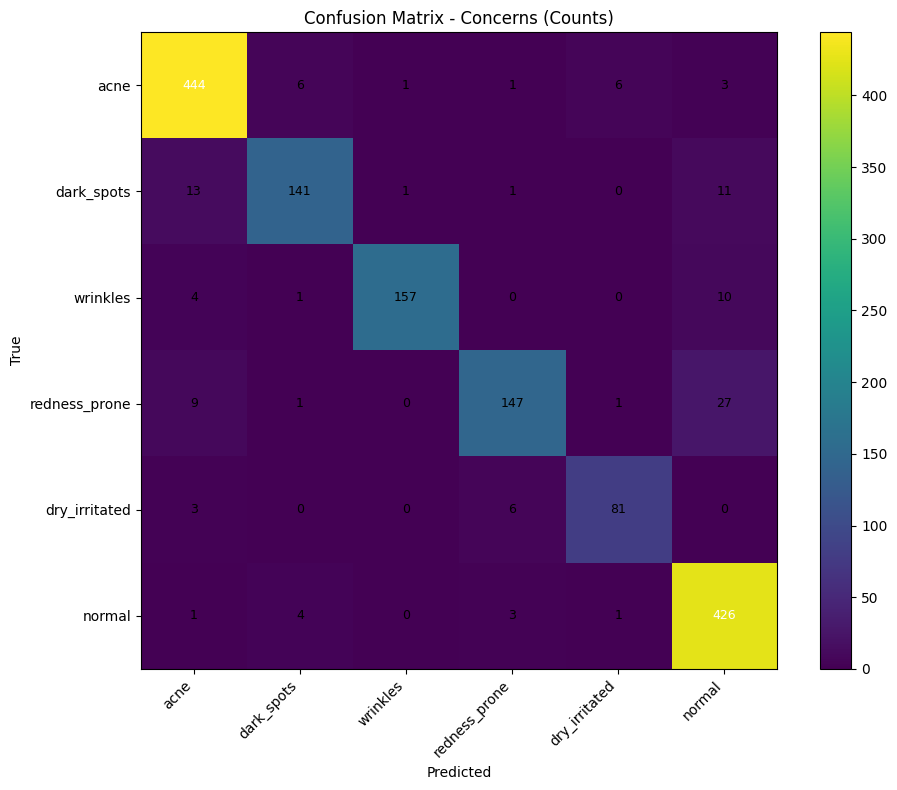

✅ Saved CM with numbers: /content/drive/MyDrive/SkinCare_AI_Component/results/confusion_matrices/concerns_confusion_matrix_counts.png


In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Save metrics JSON (same as before) ---
metrics_path = RESULTS_DIR / "metrics" / "concerns_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(report_dict, f, indent=2)
print("✅ Saved metrics:", metrics_path)

# --- Plot confusion matrix with values inside cells ---
cm_np = np.array(cm)

plt.figure(figsize=(10, 8))
plt.imshow(cm_np)
plt.title("Confusion Matrix - Concerns (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), target_names_all, rotation=45, ha="right")
plt.yticks(range(num_classes), target_names_all)
plt.colorbar()
plt.tight_layout()

# Write numbers inside each cell
max_val = cm_np.max() if cm_np.size else 0
thresh = max_val * 0.5  # switch text color based on intensity

for i in range(cm_np.shape[0]):
    for j in range(cm_np.shape[1]):
        val = int(cm_np[i, j])
        plt.text(
            j, i, str(val),
            ha="center", va="center",
            color=("white" if val > thresh else "black"),
            fontsize=9
        )

cm_path = RESULTS_DIR / "confusion_matrices" / "concerns_confusion_matrix_counts.png"
plt.savefig(cm_path, dpi=250, bbox_inches="tight")
plt.show()
print("✅ Saved CM with numbers:", cm_path)


In [15]:
samples_path = RESULTS_DIR / "sample_outputs" / "concerns_samples.txt"

lines = []
for i in range(min(50, len(all_paths))):
    t = id_to_label[all_true[i]]
    p = id_to_label[all_pred[i]]
    lines.append(f"{all_paths[i]} | true={t} pred={p}")

samples_path.write_text("\n".join(lines))
print("✅ Saved samples:", samples_path)
print("\n".join(lines[:10]))


✅ Saved samples: /content/drive/MyDrive/SkinCare_AI_Component/results/sample_outputs/concerns_samples.txt
data/10_images/splits/test/acne/07Acne081101.jpg | true=acne pred=acne
data/10_images/splits/test/acne/07Acne0811011 - Copy.jpg | true=acne pred=acne
data/10_images/splits/test/acne/07RosaceaFulFAce1.jpg | true=acne pred=acne
data/10_images/splits/test/acne/07SteroidPerioral11 - Copy.jpg | true=acne pred=acne
data/10_images/splits/test/acne/1.png | true=acne pred=acne
data/10_images/splits/test/acne/182.JPG | true=acne pred=acne
data/10_images/splits/test/acne/2 (13)1.jpeg | true=acne pred=acne
data/10_images/splits/test/acne/2 (3)1.jpeg | true=acne pred=acne
data/10_images/splits/test/acne/2 (51).jpg | true=acne pred=acne
data/10_images/splits/test/acne/2 (54)1.jpg | true=acne pred=acne


In [16]:
import torch.nn.functional as F

def predict_concern(relative_image_path: str):
    img = Image.open(PROJECT_ROOT / relative_image_path).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    pred_id = int(np.argmax(probs))
    return {
        "pred_label": id_to_label[pred_id],
        "confidence": float(probs[pred_id]),
        "probs": {id_to_label[i]: float(probs[i]) for i in range(num_classes)}
    }

print(predict_concern(all_paths[0]))


{'pred_label': 'acne', 'confidence': 0.9988792538642883, 'probs': {'acne': 0.9988792538642883, 'dark_spots': 8.867936412570998e-05, 'wrinkles': 5.202498141443357e-05, 'redness_prone': 6.491517706308514e-05, 'dry_irritated': 0.0008933581993915141, 'normal': 2.1773781554657035e-05}}
